# **Clustering**

In this NB, we will apply what was learnt about tensor operations in the `01_matmul` notebook to classical ML algorithms - specifically unsupervised learning techniques like Clustering. 

The homework at the end of the course NB is the key to this lesson. We should be able to extend tensor operations to other unsupervised algorithms such as dbscan, k-means clustering , fast nearest neighbours _while utilizing our GPU._ Implementing in APL is the bonus.

According to Jeremy, this is akin to knowing our times tables. So "time" to get cracking!

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create Synthetic Data

In [3]:
n_clusters = 6
n_samples = 500

We will pick 6 random points aka centroids and for each we will generate 500 random observations.

In [4]:
# Create random clusters by 2 for x and y coordinates
centroids = torch.rand(n_clusters, 2) * 70-35

In [5]:
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [6]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [12]:
# Sample will run on each of the 6 centroids
def sample(m): 
    # Returns normally distributed, multivariate data with means for x and y
    # The standard deviation and mean will be 5 for these clusters. 
    # torch.diag() will create a covariance matrix since we have multivariate data.
    # finally, get the number of samples which we want.
    return MultivariateNormal(m, torch.diag(tensor([5., 5.]))).sample((n_samples,)) # Comma ensures output is a tuple

**`NOTE`** 

With regard to `.sample(n_samples,)`, here are some additional details with regard to ChatGPT.

> The sample method can take a shape argument to specify how many samples you want to draw. By passing `(n_samples,)`, you're specifying that you want to draw `n_samples` samples from the distribution, and the comma makes this a tuple. In Python, a single-element tuple _must_ have a comma after the element to distinguish it from a regular parenthesized expression.

> Without the comma, `(n_samples)` would just be interpreted as n_samples itself, rather than a tuple containing n_samples. Using a tuple ensures that the sample method interprets the argument correctly and returns the desired number of samples.

In [13]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([3000, 2])

In [14]:
torch.cat?

Docstring:
cat(tensors, dim=0, *, out=None) -> Tensor

Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
All tensors must either have the same shape (except in the concatenating
dimension) or be a 1-D empty tensor with size ``(0,)``.

:func:`torch.cat` can be seen as an inverse operation for :func:`torch.split`
and :func:`torch.chunk`.

:func:`torch.cat` can be best understood via examples.

.. seealso::

    :func:`torch.stack` concatenates the given sequence along a new dimension.

Args:
    tensors (sequence of Tensors): any python sequence of tensors of the same type.
        Non-empty tensors provided must have the same shape, except in the
        cat dimension.
    dim (int, optional): the dimension over which the tensors are concatenated

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> x = torch.randn(2, 3)
    >>> x
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497]])
    >>> torch.cat(

In [10]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: 
        _, ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        #Grab samples in order for i to i+1
        samples = data[i*n_samples: (i+1)*n_samples]
        ax.scatter(samples[:, 0], samples[:, 1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color="k", mew=5) # Large black X
        ax.plot(*centroid, markersize=5, marker="x", color="m", mew=2) # Smaller magenta X

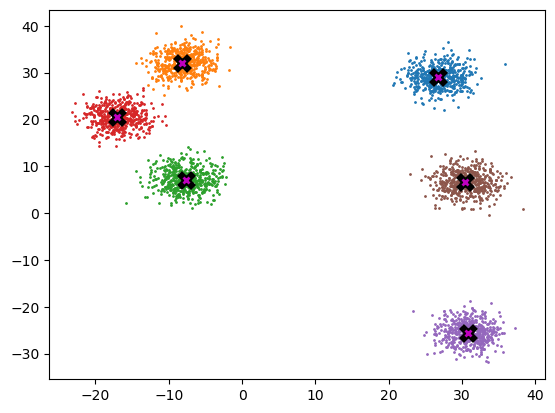

In [11]:
plot_data(centroids, data, n_samples)

## Mean Shift Algorithm

> Most people that have come across clustering algorithms have learnt about k-means. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
> - It doesn't require selecting the number of clusters in advance, but instead just requires a bandwidth to be specified, which can be easily chosen automatically
> - It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

> The algorithm is as follows:

> - For each data point x in the sample X, find the distance between that point x and every other point in X
> - Create weights for each point in X by using the Gaussian kernel of that point's distance to x
> - This weighting approach penalizes points further away from x
> - The rate at which the weights fall to zero is determined by the bandwidth, which is the standard deviation of the Gaussian
> - Update x as the weighted average of all other points in X, weighted based on the previous step

>This will iteratively push points that are close together even closer until they are next to each other.


In [16]:
# Taking the mean gives us the middle point of the variable space
# This is not the result we want. Our interest lies in taking a weighted average
midp = data.mean(0)
midp

tensor([ 9.180, 11.603])

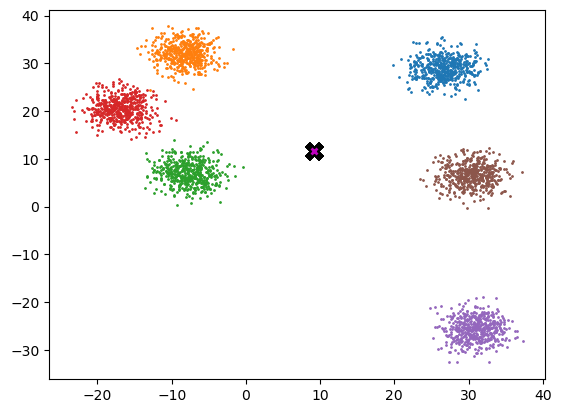

In [17]:
plot_data([midp]*6, data, n_samples)

We require a weighted average of the data points for each cluster. Each point's weights are assigned using the Gaussian Kernel.

In [25]:
def gaussian(d, bw):
    # Computes the value of a Gaussian distribution's PDF
    # d=distance and bw=bandwidth
    # d/bw normalizes the distance by bw - which acts as a scaling factor
    
    # (-0.5*((d/bw)**2)) computes the exponent in the Gaussian function.
    # Squaring the normalized distance ensures a non-negative result. -0.5 changes the sign.

    #The term math.sqrt(2 * math.pi) is a constant that ensures the integral of the Gaussian function 
    # over all space equals 1, making it a valid probability density function. 
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [19]:
def plot_func(f):
    x = torch.linspace(0, 10, 100)
    plt.plot(x, f(x))

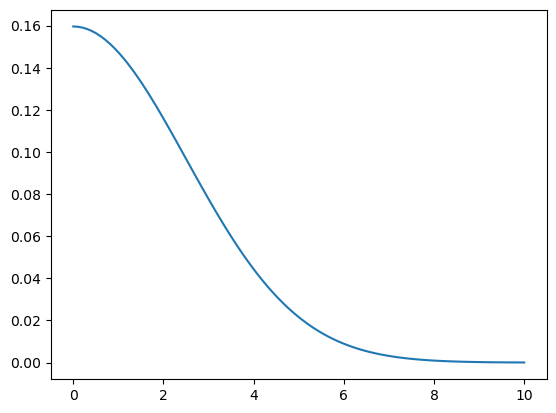

In [24]:
# We can use partial() to simplify the plotting of the function below
plot_func(partial(gaussian, bw=2.5))

Setting `bw` or `bandwidth` to 2.5 is a rule of thumb which allows us to cover 75% of the data.

A simpler alternative is to use triangular weighting for setting the bandwidth.

In [26]:
def tri(d, i):
    return (-d+i).clamp_min(0)/i

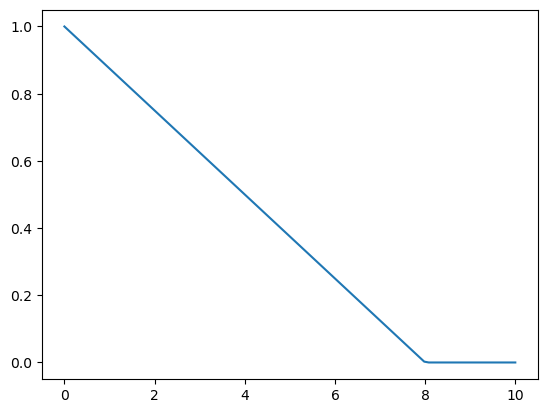

In [27]:
plot_func(partial(tri, i=8))

In [50]:
# Cloning the data by creating matrix X
X = data.clone()
x = data[0]

In [51]:
# A simple rank 1 tensor which will be used to calculate the distances from x and y
x

tensor([26.070, 31.756])

In [52]:
# Tensors and then adding a unit column to x
x.shape, X.shape, x[None].shape

(torch.Size([2]), torch.Size([3000, 2]), torch.Size([1, 2]))

Applying what was learnt in the last NB wrt Broadcasting rules.

In [53]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 4.271,  7.051],
        [-2.848,  1.672],
        [ 2.488,  2.145],
        [-1.644,  3.903],
        [ 1.433,  2.529],
        [-2.395,  0.646],
        [ 0.785,  2.151]])

In [54]:
(x-X)[:8] # Same result as before since our tensors have compatible unit axes

tensor([[ 0.000,  0.000],
        [ 4.271,  7.051],
        [-2.848,  1.672],
        [ 2.488,  2.145],
        [-1.644,  3.903],
        [ 1.433,  2.529],
        [-2.395,  0.646],
        [ 0.785,  2.151]])

In [55]:
# Taking the Euclidean distance 
dist_1 = ((x-X)**2).sum(1).sqrt()
dist_1[:8]

tensor([0.000, 8.244, 3.302, 3.285, 4.236, 2.907, 2.481, 2.290])

**HOMEWORK**: Lets rewrite the above using Einsum to speed up operations.

In [58]:
# Einsum implementation
# Compute the squared differences, take their sum and then the square root.
ein_dist = torch.einsum('ij, ij -> i', (X-x), (X-x)).sqrt()
ein_dist[:8]

tensor([0.000, 8.244, 3.302, 3.285, 4.236, 2.907, 2.481, 2.290])

In [62]:
# Calculating the weights, using both the standard and the einsum versions
weight_1 = gaussian(dist, 2.5)
weight_2 = gaussian(ein_dist, 2.5)

In [60]:
# We will calculate the weighted average of the data X using the weights we just calculated.
weight_1.shape, weight_2.shape ,X.shape

(torch.Size([3000]), torch.Size([3000]), torch.Size([3000, 2]))

In [61]:
# To make the tensors compatible for operations requires a unit axis
weight_1[:, None].shape, weight_2[:, None].shape

(torch.Size([3000, 1]), torch.Size([3000, 1]))

In [63]:
(weight_1[:, None]*X)[:8], (weight_2[:, None]*X)[:8]

(tensor([[4.160, 5.068],
         [0.015, 0.017],
         [1.929, 2.006],
         [1.587, 1.993],
         [1.053, 1.058],
         [2.000, 2.372],
         [2.776, 3.034],
         [2.652, 3.105]]),
 tensor([[4.160, 5.068],
         [0.015, 0.017],
         [1.929, 2.006],
         [1.587, 1.993],
         [1.053, 1.058],
         [2.000, 2.372],
         [2.776, 3.034],
         [2.652, 3.105]]))

Thankfully, both the **standard** and the **einsum** versions appear to have similar values.

Now that we have iteratively figured out how to get the individual pieces of the mean shift algorithm to work, its time to put it into one function.

Additionally, we can compare the difference in performance for both versions of our weight calculations.

In [64]:
def one_update(X, calc=None):
    for i, x in enumerate(X):
        if calc =='einsum':  dist = torch.einsum('ij, ij -> i', (X-x), (X-x)).sqrt()
        else:                dist = torch.sqrt(((x-X)**2).sum(1))
        # We can use the gaussian or the triangular weighting since the results will be the same.
        #weight = gaussian(dist, 2.5) # where d is dist
        weight = tri(dist, 8)
        X[i] = (weight[:, None] * X).sum(0) / weight.sum()

In [65]:
def mean_shift(data, calc=None):
    X = data.clone()
    for it in range(5): one_update(X, calc=calc)
    return X

In [69]:
%time X = mean_shift(data)

CPU times: user 11.3 s, sys: 179 ms, total: 11.5 s
Wall time: 1.15 s


In [70]:
%time X = mean_shift(data, calc='einsum')

CPU times: user 13.7 s, sys: 208 ms, total: 13.9 s
Wall time: 1.39 s


Interestingly, the **einsum** version is slower than the standard version.

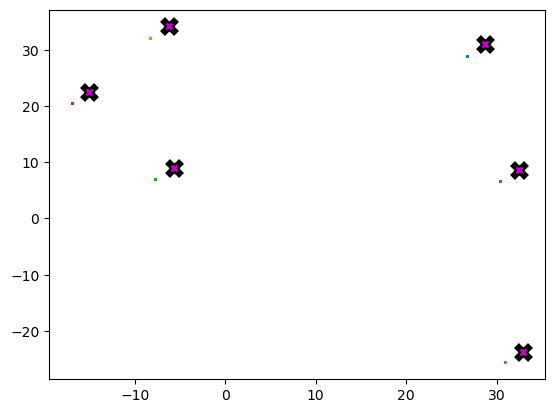

In [68]:
# We will move the centroids by 2 points to see them better
plot_data(centroids + 2, X, n_samples)

## Animating the Training / Optimization Steps

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
def one_step(d):
    if d: one_update(X)
    # Adding clear() so that outputs don't overlap
    ax.clear() 
    plot_data(centroids+2, X, n_samples, ax=ax)

In [ ]:
# Creating an animation of the optimization steps
X = data.clone()
fig, ax = plt.subplots()
ani = FuncAnimation(fig, one_step, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## Speeding Up Operations Using GPU Batched Algorithm

Before moving the algorithm's operations over to the GPU, we need to be aware of the considerable communications overhead between the flow of data between the CPU and GPU. This is called the **Kernel Launch Overhead** and more details on this topic can be found in this [paper](https://www.hpcs.cs.tsukuba.ac.jp/icpp2019/data/posters/Poster17-abst.pdf).

Functionally, we will do away with the model's loop and replace it with broadcasting.

In [ ]:
# Create a batch size
bs = 5
X = data.clone()
# Small x will be used for testing the number of items based on the batch size.
# Starting off with 5
x = X[:bs]
x.shape, X.shape

We need to rework our distance calculation which can return a matrix containing item-wise distances. Bear in mind that matrix compatibility needs to be considered before running these calculations.

In [ ]:
# Unit axes need to be added for compatibility
# x[None] == x[None, :]
x[None].shape, X[:, None].shape, (x[None, :] - X[:, None]).shape

In [ ]:
# Now that our matrices align, lets define the distance function
def dist_b(a, b):
    return (((a[None] - b[:, None])**2).sum(2)).sqrt()

In [ ]:
dist_b(X, x)

In [ ]:
dist_b(X, x).shape

In [ ]:
# Using the Gaussian function from before
weight = gaussian(dist_b(X, x), 2)
weight

In [ ]:
weight.shape, X.shape

In [ ]:
# Adding unit axes
weight[..., None].shape, X[None].shape

In [ ]:
# Testing the output of the matrix multiplication
# Numerator for the weighted average
num = (weight[..., None] * X[None]).sum(1)
num.shape

In [ ]:
num

Since we're working with products and sums, we can use Einsum for cleaner code. Here we need to remember that:
- `weight` which is (5, 3000) will be `ij`.
- `X` is (3000, 2) will be `jk`.
- `ik` is the result.

In [ ]:
torch.einsum('ij, jk -> ik', weight, X)

In [ ]:
# PyTorch operations are cleaner still
weight @ X

In [ ]:
# The denominator for weighted avg. here is the sum of the weights
div = weight.sum(1, keepdim=True)
div

In [ ]:
# Weighted average, all cleaned up
num / div

In [ ]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            # Slicing the batches for repeated ops
            s = slice(i, min(i+bs, n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
            # This time we won't be using triangular 
        #   weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X / div
    return X

In [ ]:
# Moving things over to cuda
data = data.cuda()

In [ ]:
X = meanshift(data).cpu()

In [ ]:
# Testing various batch sizes
%timeit -n 5 _= meanshift(data, 20).cpu()

In [ ]:
# Testing various batch sizes
%timeit -n 5 _= meanshift(data, 100).cpu()

In [ ]:
# Testing various batch sizes
%timeit -n 5 _= meanshift(data, 500).cpu()

In [ ]:
# Testing various batch sizes
%timeit -n 5 _= meanshift(data, 1000).cpu()

In [ ]:
# Testing various batch sizes
%timeit -n 5 _= meanshift(data, 3000).cpu()

In [ ]:
plot_data(centroids+2, X, n_samples)